## Proposal Report : Power Price Prediction

### Contributors

- Arjun Radhakrishnan
- Sneha Sunil
- Gaoxiang Wang
- Mehdi Naji

### Executive Summary 

Our proposed business solution aims to build an interpretable and explainable data science product ready to be deployed on the cloud for power price prediction in Alberta Energy Market. Our solution can enable organizations to make informed decisions about their energy purchases by forecasting hourly energy prices in advance, along with confidence intervals. The solution will also address the lack of interpretability and explainability in the current system[[1]](https://aeso-portal.powerappsportals.com/data-portal-dashboard/). This product will be accompanied by an intuitive tableau dashboard showcasing relevant visualizations to enable stakeholders to monitor real-time hourly predictions with a margin of error.

### Introduction

### Introduction to Data

### Data Science Techniques


To address the challenges faced by organizations in Alberta, our cutting-edge product offers a comprehensive solution that empowers them to effectively analyze costs, optimize energy purchases, and ultimately maximize their profits. The scientific objectives of our product are 

- Forecasting energy prices for the next 12 hours
- Interpretability of predictions 
- Scalable and Realtime prediction pipeline
- Reactive Tableau Dashboard for visualizing the real-time results

Our project utilized two primary data sources: 

**Historical Time-series Data**: This dataset, publicly accessible through Tableau, spans from 2015 to 2023. With approximately 72,000 observations, it encapsulates 110 distinct features.

**Open-source API Data** : Through a public API service which is hosted by AESO, we  can avail the real-time and historical data for certain selective features.

Our initial dataset incorporated approximately 110 features. These features consisted of information about  power generation/supply by fuel type, energy load distribution across regions, import and export data, and system marginal price data. The main target that we are forecasting 12 hours in advance is the power pool price (CAD) which is the balanced average power price per hour for the Alberta province and is finalized by AESO based on supply and demand. It is capped between 0 and 1000 to ensure that the Alberta electricity market is stable and fair. Our feature set predominantly comprises numerical data, with one exception of an ordinal feature.

For the modelling purpose, we partitioned our data into two subsets: training and testing. The training data encompasses the period from January 2022 to January 2023, while the test set refers to the data from February 2023. Given the absence of real-time data of all features through the API, we leveraged historical data to simulate a real-time system. The simulated system provides real time predictions starting from February 1, 2023. When real-time data becomes accessible for the clients, they can seamlessly swap the data sources, thereby enabling real-time data flow into the model which will make real time predictions.


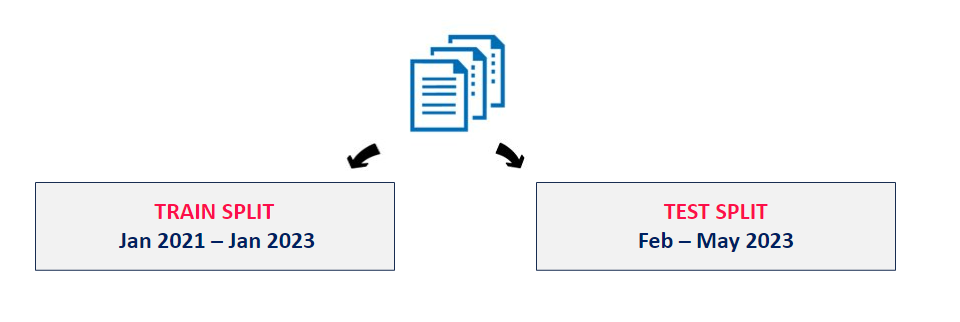

#### Data preprocessing

In our pursuit to accurately predict future prices based on historical values and other influential factors like supply and demand, we transformed the time-series data into a tabular format. This involved creating lagged versions of the various features, including price, paired with the corresponding target price for each specific hour. To address the inherent challenges of our target variable - price like extreme volatility we attempted several transformation techniques:

`Log Transformation`: Given the skewed nature of the price data, a logarithmic transformation was used with an intent to normalize its distribution. This transformation could potentially make patterns in the data more interpretable and better meet the assumptions of downstream modeling techniques.

`Standard Scaler`: The standard scaler transformation was applied to standardize the price values. This technique could help minimize the effect of outliers and varying scales across different features by scaling the values to have a mean of 0 and a standard deviation of 1.

`Discretization`: The discretization transformation was used as it often complements tree-based models such as LightGBM, improving their performance by turning continuous features into several bins, each representing a range of price values.

Despite these efforts, none of these transformations led to significant improvements in our model's predictive performance. Consequently, we decided to proceed with the original scale of the price variable. This approach might also simplify the interpretation and communication of the model results, as the predictions will be in the same scale as the original data.


#### Feature Selection and Engineering

In the process of feature selection, our primary strategy involved examining the correlations between various features and the price in the preliminary round. Subsequently, we further refined our selection by leveraging the coefficients from an Elastic Net model, and the feature importances deduced from training a Random Forest Regressor model. 

Pursuing a second strategy, we investigated the correlation between lagged features and future prices projected for periods ranging from 1 to 12 hours. We identified features exhibiting correlations of absolute value greater than 0.3 and incorporated them into our feature set. Interestingly, both strategies resulted in almost identical sets of features.

Upon finalizing our feature set, considering the importance of interpretability in our model, we conducted comprehensive market research and engineered several key features showing significant correlation with the price. One such feature is the load on gas reserve, a buffer/reserve of energy, readily available to meet sudden load demands and peak usage hours. As evidenced in our data visualizations, a dwindling gas reserve tends to correspond with an increase in price. In case of gas supply mix which is the proportion of energy generation using gas by the total energy generation, when the supply is mostly using gas, the price increases as gas is costly compared to the rest of the sources. 


Link to the glossary

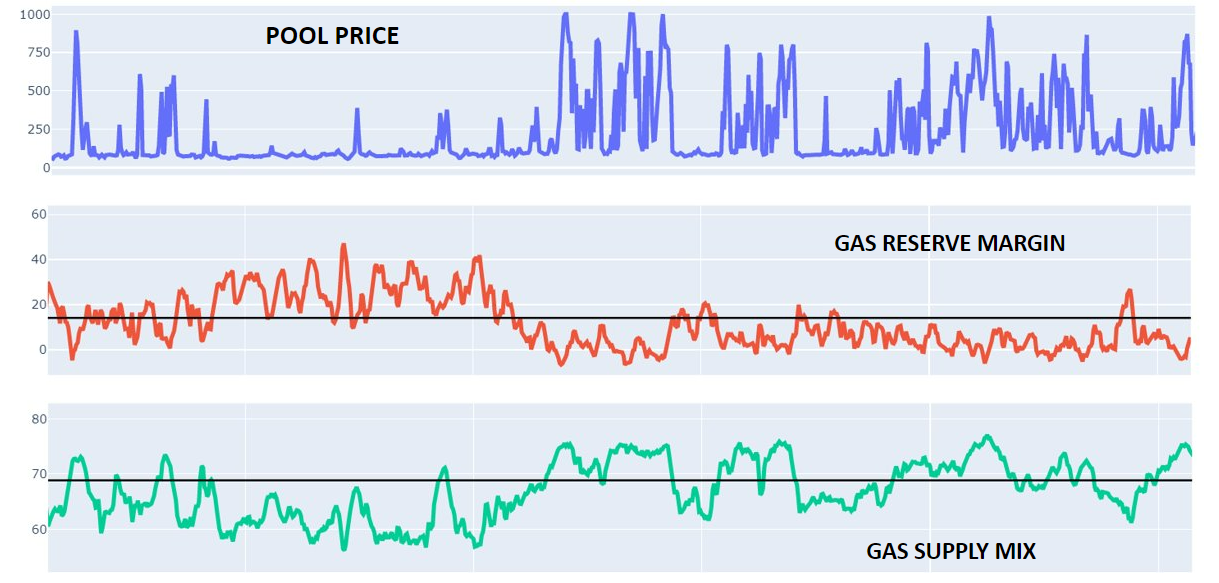

It's worth noting that we found some features to be inter-correlated, suggesting that Principal Component Analysis (PCA) could potentially streamline our dataset by reducing dimensionality. However, PCA tends to complicate feature interpretability, presenting a challenge for end-users. While PCA offers benefits such as reducing computational burden and enhancing model performance, these gains must be weighed against the increased complexity and reduced interpretability. As such, we elected not to employ PCA in our model development.


#### Modelling Strategy

Since the price is extremely volatile, tackling our first scientific objective which is forecasting energy for the next 12 hours seemed like a complex task. Hence, we needed models that is apt for time series forecasting which is able to pick up the temporal patterns. Computational efficiency for initial training and repeated updates was also needed. As a baseline model for our problem, we chose the SARIMA model which is a classical model as it fulfilled the above requirements and also supported probabilistic forecasting. It was also possible to obtain confidence intervals using this model.  Using SARIMA, we performed univariate forecasting, predicting the future values of the price based on the past values of the price alone. The results were not up to the mark where we got an average error of 183 CAD with a standard deviation in errors as approx. 132 CAD.  

Since ours is a multi step forecasting problem, we then decided to switch to more sophisticated machine learning models as the classical statistical model did not give us good results. Here instead of just relying on the past values of the price alone, we incorporated the key engineered features that we had developed. 

In terms of prediction strategy for the multistep forecasting problem, we chose the **direct strategy** over the recursive strategy. In recursive strategy, we iteratively forecast the future time step values using the predicted values. This means that the model is first trained with historical data uptil the cut off point. The cut off hour refers to the specific point in time up to which you use the data to train your model. Once the model is trained, an initial prediction is made for the next time step after the cut off point which is then again used to train the model and used as an input for the next prediction. We did not use this strategy for our modelling pipeline because the prices are extremely volatile and the recursively predicting price would propagate errors making the pipeline unstable and predictions unreliable. 

 Since we have a forecasting horizon of 12 steps,  we went ahead with the direct strategy where we train 12 models to predict the power price for each timestep in the forecasting horizon which is 1,2, 3... 12. In this approach, all the 12 models are trained using the same data and each of this model will directly forecast the target for the required time step. For eg, at each hour, model 1 will always predict for power price one time step into the future and model 12 will always predict the price for 12 timesteps into the future. This will prevent the accumulation of errors in the initial predictions which can affect the subsequent future predictions as in the recursive strategy . Hence, the propagation of error is controlled because we dont rely on the previous predictions but on the real pool prices for each of the model. Each prediction is made independently based on each of the 12 models, leading to accurate results. Another pro is that we can generate all 12 step predictions at once, once the models are trained for each hour. When a data point becomes available, we update and train the model based on the real time data so that the future predictions are reliable. Hence, when we get a new data point, we update the cut off time by 1 hour and refit all the 12 models with the new data. One key factor that we considered while choosing our final model is its ability to update its parameters with minimum compute time.  

One disadvantage with this approach is that we will have 12 models in our pipeline which make it bulky and computationally intensive. Moreover, once a data point is avaialable, we will have to refit the data along with the new data point to all the 12 models which can be time consuming. 

We used the sktime package for building our base pipeline as it is one of the most popular packages that supports time series forecasting which enables us to use  machine learning models on the time series data. Once the features were engineered, data was preprocessed and pipeline was set up, we extensively researched on the models that were a good fit for our problem. We especially checked for models that provides accurate predictions , scalable and handles multicollinearity within the data.

#### Experimented models

 Our first choice was Elastic Net CV which is a  linear regression model that handles multicollinearity well and  supports feature selection. Since interpretibility was also a main focus for us, linear model would be a good choice as it is easy to interpret. Results - 

Next we tried random forest regressor model which is an ensemble model which constructs multiple decision trees at the training time and outputs the mean predictions of the individual trees. This model reduces overfitting. We also tried XGBoost  which is a gradient boosting algorithm which is efficient and checked off our requirements.
Finally, we integrated the light GBM model in our pipeline as it checked off all our requirements. It can handle large datasets with relatively shorter fit times, especially when loaded on a GPU. Additionally, light GBM supports warm initialization, refitting the model on new data extremely fast.

#### Cross Validation 

Once we selected a set of our models, we then performed cross validation for all these models. Our training data was from Jan 1st 2022 - Jan 31st 2023. From this split, we took one year worth of data as the initial training window to capture any seasonality in the price variation over time. The data for the entire month of Jan 2023 was used to create 63 folds to validate our model. Since ours is time series data, we had to ensure that temporal order of data was maintained in all the folds. 
Our first fold comprises of an initial training window of 1 year and validation set of 12 hours of data. We make the predictions for these 12 hours and compare it with the actual prices in the validation set  to get the errors.  Next, we expand the training window by including these 12 hours of data and start predicting for the next 12 hours.  This process goes on till 63 folds. 

We have chosen the metric as **RMSE - Root mean square error**. Since interpretibility was an important focus for our project, we choose RMSE as it is easily understandable and is in the same scale as the values. The unit is CAD/MW.

#### Cross Validation Results 

In the comparison of various machine learning models for forecasting purposes, the Light GBM model exhibited the best performance with an RMSE of 86.48 and a Std Dev of 77.60 (Cad/MW). Although it showed a relatively high Std Dev, indicating a wider range of prediction errors, its low RMSE, which signals a higher accuracy, took precedence, making it the superior model amongst those evaluated.

The other models demonstrated varying performance levels. XGBoost, with a slightly higher RMSE of 89.12 and almost identical Std Dev of 77.67, performed nearly as well as Light GBM. But Light GBM is computationally more efficient and have lower fit times when compared to XGBoost. The Random Forest Regressor offered decent performance with an RMSE of 120.65 and Std Dev of 75.57, while the ElasticNetCV had an RMSE of 102.85 and the lowest Std Dev of 74.04. The ARIMA model yielded the least favorable results being the baseline model with the highest RMSE of 183.40 and a Std Dev of 128.20. 

#### Interpretibility of predictions 

For our second scientific objective, which is obtaining the features importances, we relied on the **SHAP (SHapley Additive exPlanations)** which helps us in interpreting and explaining the predictions of our model. For each prediction the model make, we can easily obtain the SHAP values of each of the features for this prediction, which will quantify the impact and contribution of each feature for the prediction. This enable local interpretibility and explain ability of the predictions. We have a base value which is the average value of the predictions made by the model, also called as the model's expected output. This will act as a reference point for comparing the impact of each feature. The SHAP values can be positive or negative. If a SHAP value is positive it means that that feature positively influenced the prediction and pushed the prediction value to be higher than the base score and vice versa for the negative values. So in our dashboard, we have specifically depicted how much percentage increase/decrease each feature contributed in the current prediction when compared to the base score. 

#### Quantifying Uncertainity

For quantifying the uncertainity of our predictions, we are obtaining the 95% confidence intervals by using Quantile regression. As our final model Light GBM supports quantile regression, we trained two separate lightGBM models which objective as quantile regression. One model was trained to give the upper limit of the confidence interval by configuring the desired quantile as 0.975 (97.5th percentile) and the second model was trained to output the lower limit of the interval by configuring the desired quantile as 0.025 (2.5th percentile). We obtain these limits/predicted quantiles for the 95% confidence interval after training the models by using predict() method for each prediction. 


#### Test Results 

Coming to the most awaited test results, our modelling pipeline outperformed AESO's model across all timesteps as shown in the table. Our prediction pipeline demonstrates superiority not just in short-term 1-step and 2-step forecasts but continues to maintain lower RMSE values across multiple steps, right up to 12-step forecasts. Importantly, our model also has the capacity to make forecasts beyond the 6-step limit of the AESO model. This extended range and increased accuracy throughout the forecasting horizon underscore the enhanced performance and superior predictive power of our model compared to the AESO model.

It is noteworthy that the RMSE of our model consistently stays in a relatively lower range, even at higher step predictions. This implies that our model's accuracy doesn't degrade significantly with the extension of the forecast horizon, which is a highly desirable feature in multi-step forecasting models. Overall, this analysis establishes the robustness and efficacy of our prediction pipeline in multi-step forecasting.

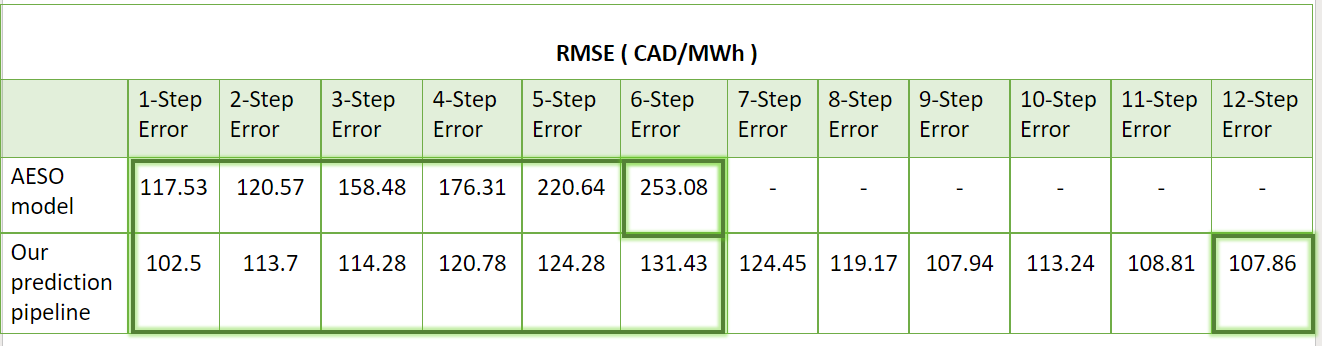

#### Deployment Architecture 

Inorder to make our machine learning pipeline scalable, we have deployed our product in Databricks. Our architecture involves two main jobs running within Databricks. We also have two storage units - one for storing the predictions for dashboard and the second one for archiving all the predictions made by the model. The first job serves as our initial training pipeline, responsible for training the model using the training dataset and subsequently saving it. We also store the model predictions, upper and lower limits, as well as the prediction explanations. These details are stored in both the real-time predictions table and the archive table.

To ensure the continuous availability of updated insights, our tableau dashboard regularly retrieves new data from the real-time predictions table and refreshes its charts accordingly. This mechanism enables us to monitor the latest trends and patterns in a visual and intuitive manner.

In addition to the initial training pipeline, we have implemented an update job that runs on an hourly basis. This job retrieves the new actual power price for the past hour, typically published by the AESO API, every hour. However, due to current limitations in data availability, we simulate this process using historical data. The update job leverages these new values to refit the data in all 12 models, thereby generating the next set of predictions. These updated predictions are then seamlessly integrated with Tableau, allowing us to promptly update our visualizations and plots.

To ensure timely and accurate generation of real-time hourly predictions, the update job operates on a timer trigger, guaranteeing that our predictions and other artifacts remain up to date and aligned with the latest data. This regular and automated update cycle empowers us to gain real-time insights and make informed decisions based on the most recent information available.

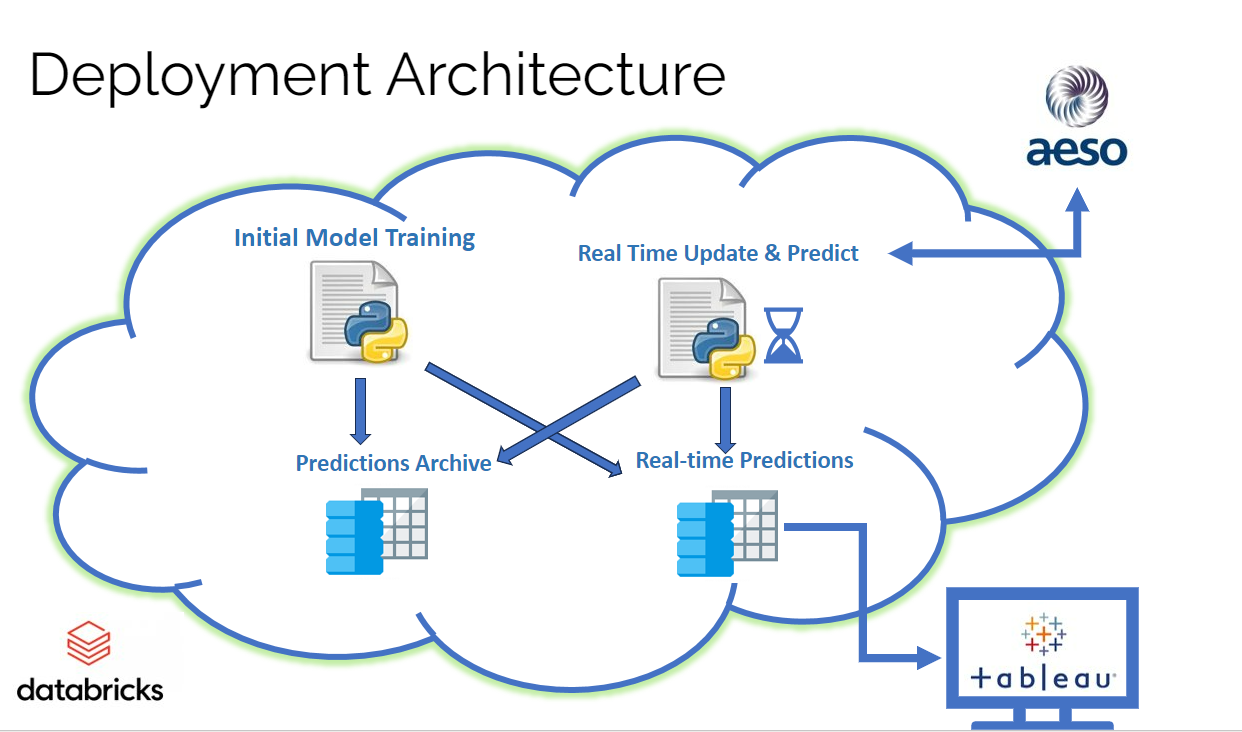